<a href="https://colab.research.google.com/github/Chou-fang/report/blob/main/k_means_ART_CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # 如果在 Colab

# 你的原始影像
# image = cv2.imread('your_image.jpg')
output_image = image.copy()  # 建一張複製的影像，避免修改原圖

# 所有門的座標
all_door = [
    np.array([[634, 233], [740, 233], [738, 319], [634, 321]]),
    np.array([[499, 234], [602, 229], [607, 318], [509, 320]]),
    np.array([[379, 268], [470, 265], [477, 323], [469, 331], [464, 339], [465, 346], [466, 351], [396, 351], [386, 321]]),
    np.array([[266, 250], [345, 248], [356, 327], [281, 332]]),
    np.array([[182, 266], [243, 263], [254, 326], [251, 330], [246, 337], [197, 340]])
]

# 進階版 for-loop
for idx, door_poly in enumerate(all_door, start=1):
    # 計算外接矩形
    x, y, w, h = cv2.boundingRect(door_poly)

    # 建立 mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [door_poly], 255)

    # 遮罩影像
    masked_img = cv2.bitwise_and(image, image, mask=mask)

    # 裁切 ROI
    roi = masked_img[y:y+h, x:x+w]

    # 計算面積
    area = cv2.contourArea(door_poly)

    # 🔥 在 output_image 上畫出門的輪廓
    cv2.polylines(output_image, [door_poly], isClosed=True, color=(0, 255, 0), thickness=2)

    # 🔥 在門的外接矩形左上角標註 Door 編號
    text_position = (x, y - 10) if y - 10 > 10 else (x, y + 20)  # 避免文字太上面跑出圖外
    cv2.putText(output_image, f'Door {idx}', text_position,
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # 印出門的資訊
    print(f"Door {idx}: 面積 = {area:.2f} (pixels)")

    # 顯示每個門的 ROI
    cv2_imshow(roi)

    # 儲存 ROI（可選）
    # cv2.imwrite(f'door_{idx}_roi.png', roi)

# 🔥 最後，顯示整張標註後的總圖
print("標註完畢，顯示整體影像：")
cv2_imshow(output_image)

# 儲存標註後的影像（可選）
# cv2.imwrite('output_with_doors.png', output_image)


In [ ]:
all_door = [
    np.array([[634,233],[740,233],[738,319],[634,321]]),
    np.array([[499,234],[602,229],[607,318],[509,320]]),
    np.array([[379,268],[470,265],[477,323],[469,331],[464,339],[465,346],[466,351],[396,351],[386,321]]),
    np.array([[266,250],[345,248],[356,327],[281,332]]),
    np.array([[182,266],[243,263],[254,326],[251,330],[246,337],[197,340]])
 ]

polygons = [
    np.array([[626,207],[741,207],[736,321],[634,325]]), # door_cell_1
    np.array([[490,211],[605,208],[607,320],[502,326]]), # door_cell_2
    np.array([[363,219],[469,215],[478,350],[383,353]]), # door_cell_3
    np.array([[252,232],[343,225],[357,334],[270,338]]), # door_cell_4
    np.array([[160,244],[236,234],[249,333],[181,345]])] # door_cell_5
image_copy = image.copy()

# 每個 door 做處理
for i, (poly, door) in enumerate(zip(polygons, all_door)):
    poly_x, poly_y, poly_w, poly_h = cv2.boundingRect(poly)
    door_x, door_y, door_w, door_h = cv2.boundingRect(door)

    mask = np.zeros(image.shape[:2], dtype=np.uint8) # 建立空的 mask
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image, image, mask=mask) # 對原圖做遮罩
    masked_img[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] = 0
    image_copy[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] = masked_img[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] # 裁切 ROI（僅取 bounding box 區域）

    # roi = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    # area = cv2.contourArea(door) # 計算面積

    cv2_imshow(image_copy) # 顯示與儲存結果


In [ ]:
##由此開始

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import pandas as pd

In [66]:
image = cv2.imread('/content/drive/MyDrive/night/2024-08-03_79.jpg')
# image = cv2.imread('/content/drive/MyDrive/night/2024-12-17_10.jpg')# 無水門
# cv2_imshow(image)
# print(image)

##自適應共振網絡(ART)

In [67]:
class ART1:
    def __init__(self, input_size, vigilance=0.8, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.num_categories = 0
        self.bottom_up_weights = []
        self.top_down_weights = []

    def _match(self, input_vec, top_down_weight):
        # 計算匹配度
        numerator = np.sum(np.logical_and(input_vec, top_down_weight))
        denominator = np.sum(input_vec) + self.epsilon
        return numerator / denominator

    def _activate(self, input_vec):
        activations = []
        for w in self.bottom_up_weights:
            activations.append(np.sum(np.logical_and(input_vec, w)))
        return activations

    def _update_weights(self, index, input_vec):
        # 更新 top-down
        self.top_down_weights[index] = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        # 更新 bottom-up
        numer = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        denom = self.epsilon + np.sum(numer)
        self.bottom_up_weights[index] = numer / denom

    def train(self, input_vec):
        if self.num_categories == 0:
            # 初始第一類別
            self.top_down_weights.append(input_vec.copy())
            self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
            self.num_categories += 1
            return 0

        activations = self._activate(input_vec)
        candidates = np.argsort(activations)[::-1]  # 從高到低排序

        for index in candidates:
            match_score = self._match(input_vec, self.top_down_weights[index])
            if match_score >= self.vigilance:
                self._update_weights(index, input_vec)
                return index  # 成功分類

        # 無法匹配任何一類別 → 建立新類別
        self.top_down_weights.append(input_vec.copy())
        self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
        self.num_categories += 1
        return self.num_categories - 1


##建立基準mask


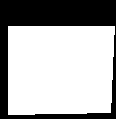

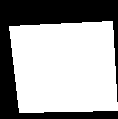

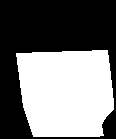

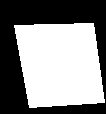

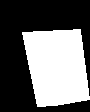

In [84]:
all_door = [
    np.array([[634,233],[740,233],[738,319],[634,321]]),
    np.array([[499,234],[602,229],[607,318],[509,320]]),
    np.array([[379,268],[470,265],[477,323],[469,331],[464,339],[465,346],[466,351],[396,351],[386,321]]),
    np.array([[266,250],[345,248],[356,327],[281,332]]),
    np.array([[182,266],[243,263],[254,326],[251,330],[246,337],[197,340]])
]

polygons = [
    np.array([[626,207],[741,207],[736,321],[634,325]]), # door_cell_1
    np.array([[490,211],[605,208],[607,320],[502,326]]), # door_cell_2
    np.array([[363,219],[469,215],[478,350],[383,353]]), # door_cell_3
    np.array([[252,232],[343,225],[357,334],[270,338]]), # door_cell_4
    np.array([[160,244],[236,234],[249,333],[181,345]])  # door_cell_5
]

image_copy = image.copy()
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

for poly in polygons:
    cv2.fillPoly(image_copy, [poly], 0)

for door in all_door:
    cv2.fillPoly(image_copy, [door], 255)

# cv2_imshow(image_copy)



for i, poly in enumerate(polygons):
    x, y, w, h = cv2.boundingRect(poly)

    # 建立空的 mask
    mask = np.zeros(image_copy.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image_copy, image_copy, mask=mask) # 對原圖做遮罩
    globals()['mask_'+str(i)] = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    cv2_imshow(globals()['mask_'+str(i)])




In [ ]:
cv2_imshow(image)

##圖片前處理

1


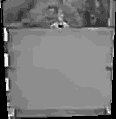

2


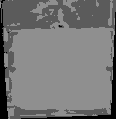

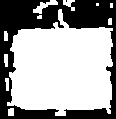

[0. 0. 0. ... 0. 0. 0.]
1


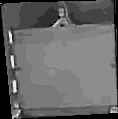

2


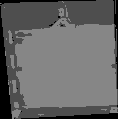

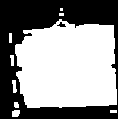

[0. 0. 0. ... 0. 0. 0.]
1


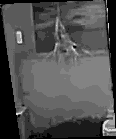

2


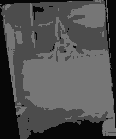

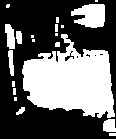

[0. 0. 0. ... 0. 0. 0.]
1


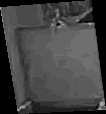

2


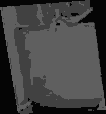

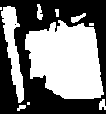

[0. 0. 0. ... 0. 0. 0.]
1


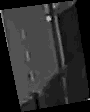

2


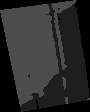

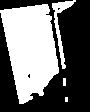

[0. 0. 0. ... 0. 0. 0.]


In [74]:
# 每個 door_cell 做處理
for i, poly in enumerate(polygons):
    x, y, w, h = cv2.boundingRect(poly)

    # 建立空的 mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image, image, mask=mask) # 對原圖做遮罩
    roi = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    # 轉換形狀
    pixels = roi.reshape(-1, 3)  # (像素, RGB)

    # KMeans 分群(第一次10群)
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype('uint8')
    segmented_image = centers[labels].reshape(h, w, 3)
    print(1)
    cv2_imshow(segmented_image)

    # KMeans 分群(第二次5群)
    pixels = segmented_image.reshape(-1, 3)
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype('uint8')
    segmented_image = centers[labels].reshape(h, w, 3)
    print(2)
    cv2_imshow(segmented_image)

    # # KMeans 分群(第三次5群)
    # pixels = segmented_image.reshape(-1, 3)
    # n_clusters = 5
    # kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # kmeans.fit(pixels)
    # labels = kmeans.labels_
    # centers = kmeans.cluster_centers_.astype('uint8')
    # segmented_image = centers[labels].reshape(h, w, 3)
    # print(3)
    # cv2_imshow(segmented_image)

    # 取出區塊特徵
    data = pd.DataFrame(columns=['重心_x', '重心_y', '面積', '與最大面積距離'])

    # 計算重心
    y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    cen_x, cen_y = [], []

    for label in range(n_clusters):
        mask = (labels.reshape(h, w) == label)

        if not np.any(mask):
            continue

        x_c = x_coords[mask].mean()
        y_c = y_coords[mask].mean()

        cen_x.append(x_c)
        cen_y.append(y_c)

    # 計算面積
    unique_labels, counts = np.unique(labels, return_counts=True)
    area = counts.tolist()

    # 儲存數據
    data['重心_x'] = cen_x
    data['重心_y'] = cen_y
    data['面積'] = area
    data['index'] = range(len(area))


    # 計算最大面積的索引
    max_index = [np.argmax(data['面積'])]

    # 計算與最大面積的距離
    dis = np.sqrt((data['重心_x'] - data.loc[max_index, '重心_x'])**2 +
                  (data['重心_y'] - data.loc[max_index, '重心_y'])**2)
    data['與最大面積距離'] = dis
    labels = [1 if value in max_index else 0 for value in labels]
    centers = np.array([[0, 0, 0],[255, 255, 255]])

    segmented_image = centers[labels].reshape(h, w, 3)
    segmented_image = segmented_image.astype(np.float32)

    # 形態學開運算
    kernel = np.ones((3,3), np.uint8)
    erosion = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)


    # cv2_imshow(segmented_image)
    erosion=cv2.cvtColor(erosion, cv2.COLOR_RGB2GRAY) # 轉灰階(三維降二維)
    cv2_imshow(erosion)
    vector = erosion.flatten() # 攤平(二維降一維)
    print(vector)


    # 二值化
    # _, binary = cv2.threshold(erosion, 128, 1, cv2.THRESH_BINARY)
    # vector = binary.flatten() # 攤平(二維降一維)


    # cv2_imshow(binary)





In [83]:


# 建立 ART1 模型並訓練
art = ART1(input_size=25, vigilance=0.85)

inputs = [mask_0]
labels = ['1']

for i, inp in enumerate(inputs):
    category = art.train(inp)
    print(f"Input '{labels[i]}' assigned to category: {category}")


Input '1' assigned to category: 0


door_cell_1 分類為類別: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


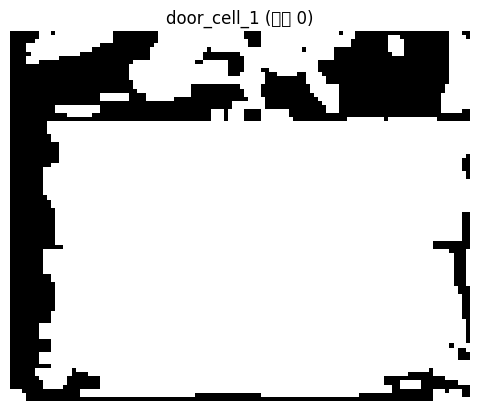

door_cell_2 分類為類別: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


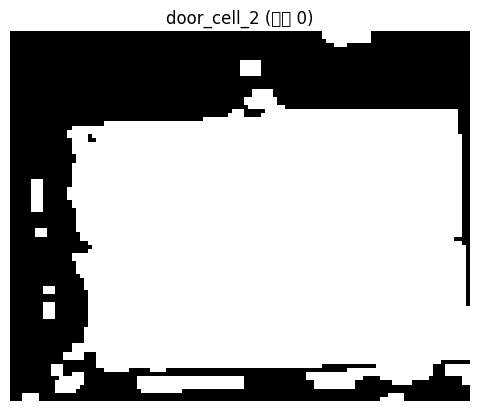

door_cell_3 分類為類別: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


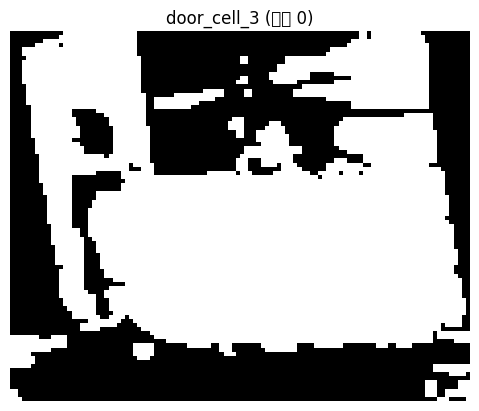

door_cell_4 分類為類別: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


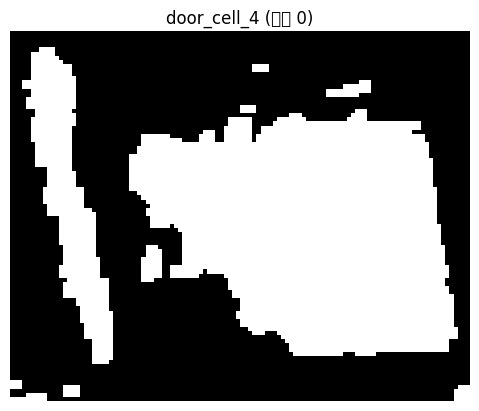

door_cell_5 分類為類別: 0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


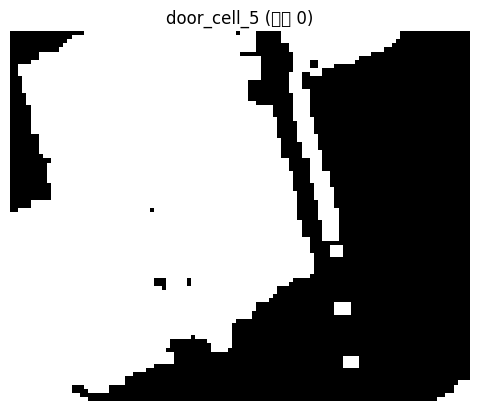

In [ ]:

# ART1 分類器應用：以 KMeans 分群與二值圖像為例

# 這份 Notebook 展示如何使用 ART1 對處理過的 door_cell 影像進行分類。

## 📦 匯入模組

import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from typing import List

## 🧠 定義 ART1 分類模型

class ART1:
    def __init__(self, input_size, vigilance=0.85, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.num_categories = 0
        self.bottom_up_weights = []
        self.top_down_weights = []

    def _match(self, input_vec, top_down_weight):
        numerator = np.sum(np.logical_and(input_vec, top_down_weight))
        denominator = np.sum(input_vec) + self.epsilon
        return numerator / denominator

    def _activate(self, input_vec):
        activations = []
        for w in self.bottom_up_weights:
            activations.append(np.sum(np.logical_and(input_vec, w)))
        return activations

    def _update_weights(self, index, input_vec):
        self.top_down_weights[index] = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        numer = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        denom = self.epsilon + np.sum(numer)
        self.bottom_up_weights[index] = numer / denom

    def train(self, input_vec):
        if self.num_categories == 0:
            self.top_down_weights.append(input_vec.copy())
            self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
            self.num_categories += 1
            return 0

        activations = self._activate(input_vec)
        candidates = np.argsort(activations)[::-1]

        for index in candidates:
            match_score = self._match(input_vec, self.top_down_weights[index])
            if match_score >= self.vigilance:
                self._update_weights(index, input_vec)
                return index

        self.top_down_weights.append(input_vec.copy())
        self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
        self.num_categories += 1
        return self.num_categories - 1

## 🔄 定義整合流程

def process_and_classify(image: np.ndarray, polygons: List[np.ndarray], input_size=(32, 32), vigilance=0.85):
    art = ART1(input_size=input_size[0] * input_size[1], vigilance=vigilance)

    for i, poly in enumerate(polygons):
        x, y, w, h = cv2.boundingRect(poly)
        roi = image[y:y+h, x:x+w]
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

        # KMeans 分群三次
        n_clusters_seq = [10, 5, 3]
        segmented_image = roi_rgb.copy()
        for n_clusters in n_clusters_seq:
            pixels = segmented_image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(pixels)
            labels = kmeans.labels_
            centers = kmeans.cluster_centers_.astype('uint8')
            segmented_image = centers[labels].reshape(h, w, 3)

        # 最大區塊分析
        pixels = segmented_image.reshape(-1, 3)
        labels = labels.reshape(h, w)
        y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        data = pd.DataFrame(columns=['重心_x', '重心_y', '面積'])

        for label in range(n_clusters_seq[-1]):
            mask = (labels == label)
            if not np.any(mask):
                continue
            x_c = x_coords[mask].mean()
            y_c = y_coords[mask].mean()
            area = np.sum(mask)
            data.loc[label] = [x_c, y_c, area]

        max_index = data['面積'].idxmax()
        dis = np.sqrt((data['重心_x'] - data.loc[max_index, '重心_x'])**2 +
                      (data['重心_y'] - data.loc[max_index, '重心_y'])**2)
        data['與最大面積距離'] = dis

        bin_labels = np.array([1 if lbl == max_index else 0 for lbl in labels.flatten()])
        centers = np.array([[0, 0, 0], [255, 255, 255]])
        segmented_image = centers[bin_labels].reshape(h, w, 3).astype(np.uint8)

        # 形態學開運算 + 灰階 + 二值化
        kernel = np.ones((3,3), np.uint8)
        morph = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)
        morph_gray = cv2.cvtColor(morph, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(morph_gray, 128, 1, cv2.THRESH_BINARY)

        # Resize + Flatten
        binary_resized = cv2.resize(binary, input_size, interpolation=cv2.INTER_NEAREST)
        vector = binary_resized.flatten()

        # 分類並顯示結果
        category = art.train(vector_copy)
        print(f"door_cell_{i+1} 分類為類別: {category}")
        plt.imshow(binary_resized, cmap='gray')
        plt.title(f"door_cell_{i+1} (類別 {category})")
        plt.axis('off')
        plt.show()

## 🔧 測試：匯入圖片與 polygon
image = cv2.imread('/content/drive/MyDrive/night/2024-08-03_79.jpg')
polygons = [
    np.array([[626,207],[741,207],[736,321],[634,325]]),
    np.array([[490,211],[605,208],[607,320],[502,326]]),
    np.array([[363,219],[469,215],[478,350],[383,353]]),
    np.array([[252,232],[343,225],[357,334],[270,338]]),
    np.array([[160,244],[236,234],[249,333],[181,345]])
]

process_and_classify(image, polygons, input_size=(112, 90), vigilance=0.85)

